In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

from IPython.display import clear_output
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/matplotlib/__init__.py:200: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/turtlebot/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
from ModifiedEnv import CartPoleEnv

env = CartPoleEnv()

In [4]:
class NeuralNet(nn.Module):
    
    def __init__(self):
        
        super(NeuralNet, self).__init__()
        
        self.Actor = nn.Sequential(
           nn.Linear(4, 16),
           nn.ReLU(),
           nn.Linear(16, 16),
           nn.ReLU(),
           nn.Linear(16, 16),
           nn.ReLU(),
           nn.Linear(16, 2),
           nn.Softmax(dim=0)
        )
        
        self.Critic = nn.Sequential(
           nn.Linear(4, 16),
           nn.ReLU(),
           nn.Linear(16, 16),
           nn.ReLU(),
           nn.Linear(16, 16),
           nn.ReLU(),
           nn.Linear(16, 1)
        )
    
    def forward(self, x):
        
        value = self.Critic(x)
        
        probs = self.Actor(x)
        dist = Categorical(probs)
        
        return dist, value

In [5]:
def plot(rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Reward')
    plt.plot(rewards)
    plt.show()

def Validation():
    
    validation_env = CartPoleEnv()
    
    observation = validation_env.reset()
    done = False
    total_reward = 0
    
    while not done:
        
        observation = torch.FloatTensor(observation)
        
        dist, _ = model(observation)
        _, action = dist.probs.max(0)
        obseravation, reward, done, _ = validation_env.step(action.numpy())
        
        total_reward += reward
    
    return total_reward


In [6]:
def Returns(value, rewards, masks, gamma=0.99):
    
    R = value
    returns = []
    
    for i in range(len(rewards)):
        
        R = rewards[i] + (gamma * R * masks[i])
        
        returns.append(R)
    
    return returns

In [7]:
model = NeuralNet()
optimizer = optim.Adam(model.parameters())
model.load_state_dict(torch.load("model_weights.pt"))

<All keys matched successfully>

In [7]:
graph_rewards = []

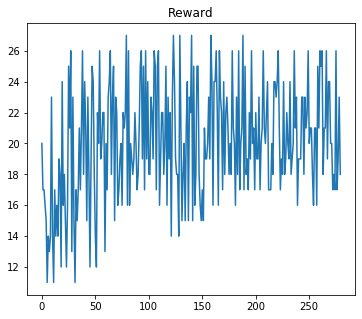

In [8]:
max_frames = 280000
frame_idx = 0
optim_freq = 80

observation = env.reset()

while frame_idx < max_frames:
    
    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0
    
    for _ in range(optim_freq):
        
        observation = torch.FloatTensor(observation)
        
        dist, value = model(observation)
        action = dist.sample()
        
        observation, reward, done, _ = env.step(action.numpy())
        
        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob.unsqueeze(0))
        values.append(value.unsqueeze(1))
        rewards.append(torch.FloatTensor([reward]).unsqueeze(1))
        masks.append(torch.FloatTensor([1 - done]).unsqueeze(1))
        
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            graph_rewards.append(Validation())
            plot(graph_rewards)
    
    observation = torch.FloatTensor(observation)
    _, value = model(observation)
    returns = Returns(value, rewards, masks)
    
    log_probs = torch.cat(log_probs)
    returns   = torch.cat(returns)
    values    = torch.cat(values)
    
    advantage = returns - values
    
    actor_loss  = -(log_probs * advantage).mean()
    critic_loss = advantage.pow(2).mean()
    
    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if done: observation = env.reset()

In [9]:
with torch.no_grad():
    testing_env = CartPoleEnv()

    for i_episode in range(1):
        observation = testing_env.reset()
        observation = torch.FloatTensor(observation)
        
        for t in range(1000):
            testing_env.render()
            dist, _ = model(observation)
            _, action = dist.probs.max(0)
            observation, reward, done, info = testing_env.step(action.numpy())
            observation = torch.FloatTensor(observation)
            #dists.append(dist)
            if done:
                pass
    testing_env.close()

In [1]:
with torch.no_grad():
    testing_env = CartPoleEnv()

    for i_episode in range(1):
        observation = testing_env.reset()
        observation = torch.FloatTensor(observation)
        frames = 0
        
        for t in range(1000000):
            dist, _ = model(observation)
            _, action = dist.probs.max(0)
            observation, _, done, _ = testing_env.step(action.numpy())
            observation = torch.FloatTensor(observation)
            dists.append(dist)
            frames += 1
            if done:
                break
        
        print(f'It survived for {frames} frames!')
        
    testing_env.close()

NameError: name 'torch' is not defined

In [23]:
#torch.save(model.state_dict(), "model_weights.pt")

In [ ]:
gym.make('CartPole-v1')